In [1]:
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-y359gx2x
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-y359gx2x
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65173 sha256=2d008b00a0bfad0d30ae28ca9417e666290db04092ad4794b500358558d66416
  Stored in directory: /tmp/pip-ephem-wheel-cache-af4umz76/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.4.5
    Uninstalling albumentations-0.4.5:
      Successfully uninstalled albumentations-0.4.5


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
%matplotlib inline


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
 os.chdir("/content/drive/My Drive/Utils")

In [6]:
from torchvision import transforms
from helper import HelperModel
from dataset_info import DataSetInfo
from dataloader import DataLoader
from models.resnet import ResNet18
from models.NewModel import newModel
# import model as md
from transforms import Transform
from train import Train
from test import Test
from plot import Plot
from tqdm import tqdm
from albumentation import Albumentation
from gradcam import GradCAM, visualize_cam
from lr_finder import LRFinder
from lr_accuracy import LRAccuracy

  pip install torch-lr-finder -v --global-option="amp"


### Create model and display summary

In [7]:

model_obj = newModel()

device = HelperModel.get_device()

model = model_obj.to(device)

#create object for helper with object
helper_obj = HelperModel(model)

#display summaru of model
helper_obj.display_model_summay(model, (3, 32, 32))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

### Get data set object

In [8]:
data_set_obj = DataSetInfo("cifa", "./data")

### Get the train test transforms 

In [9]:
import albumentations as A
import albumentations.pytorch as AP

import albumentations as A
import cv2

means = (0.5, 0.5, 0.5)
stdevs = (0.5, 0.5, 0.5)
customised_transforms =  [ 
                            A.PadIfNeeded(min_height=40, min_width=40),
                            A.RandomCrop(32,32),
                            A.HorizontalFlip(p=0.7),
                            A.Normalize(mean=means, std=stdevs),
                            A.Cutout(num_holes=1, max_h_size=8,max_w_size = 8,p=1),
                            AP.ToTensor() 
                         ]
train_transforms = Albumentation(transforms = customised_transforms)
test_transforms=Albumentation(transforms = [A.Normalize(mean=means, std=stdevs), AP.ToTensor() ])


### Get Train and Test data set

In [10]:
train_set = data_set_obj.get_train_dataset(train_transforms)
test_set = data_set_obj.get_test_dataset(test_transforms)

Files already downloaded and verified
Files already downloaded and verified


### Load the train and test data

In [11]:
data_loader_obj = DataLoader(train_set, test_set, batch_size=512)
train_loader = data_loader_obj.train_loader
test_loader = data_loader_obj.test_loader

CUDA Available? True


### Show some training images

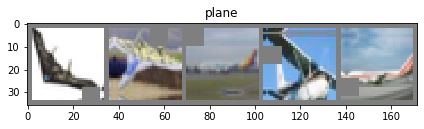

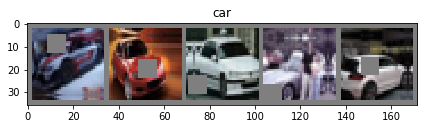

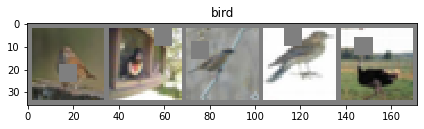

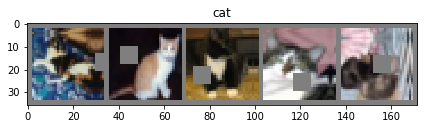

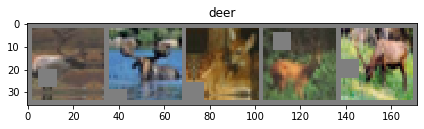

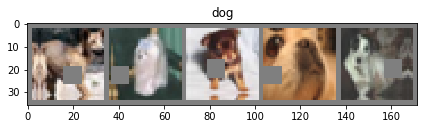

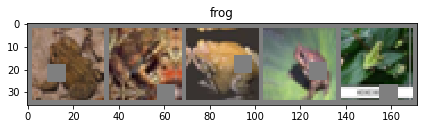

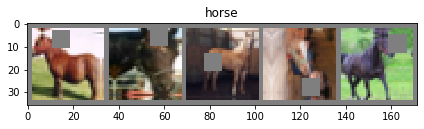

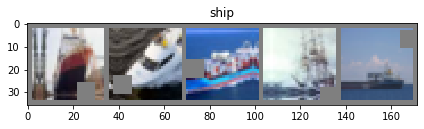

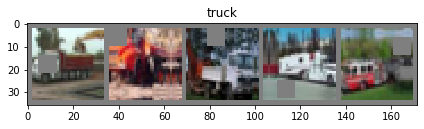

In [12]:
import torchvision
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# show images
Plot.show_cifar_classwise_image(train_loader, classes)


### Perform LR range test

In [13]:

criterion = nn.CrossEntropyLoss()
optimizer = helper_obj.get_l2_regularizer(weight_decay=0.001, lr=1e-4, momentum=0.9) #SGD with l2 regulizer
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=0.1, num_iter=10 * len(train_loader), step_mode="exp")




Learning rate search finished. See the graph with {finder_name}.plot()


### Plot Train accuracy vs Learning rate

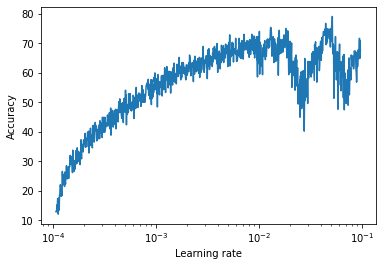

Best acc 79.1015625
Best LR:  0.05151704811905986


In [14]:


lr_finder.plot(plot_case="acc")
best_lr = lr_finder.get_best_lr(case="acc")

### Plot Loss vs Learning rate

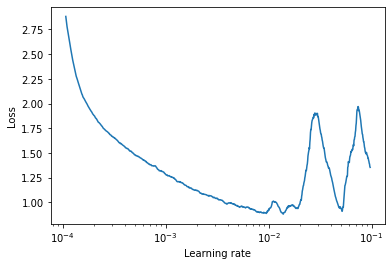

Best loss 0.8823573681898182
Best LR:  0.013866971210039032


In [15]:
lr_finder.plot(plot_case="loss")
best_loss_lr = lr_finder.get_best_lr(case="loss")

### Reset model to initial state

In [16]:
lr_finder.reset()


### Run the model

In [17]:
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import OneCycleLR


optimizer = optim.SGD(model.parameters(), lr=best_lr,momentum=0.9,weight_decay=0.001 ) 
scheduler = OneCycleLR(optimizer, max_lr = best_lr, total_steps=None, epochs=24, steps_per_epoch=len(train_loader), pct_start=0.167, anneal_strategy='linear', cycle_momentum=False, base_momentum=0.9, max_momentum=0.95, div_factor=10,final_div_factor =1)
EPOCHS = 25


train_obj = Train()
test_obj = Test()
train_max_acc = []
train_min_loss = []

criterion = nn.CrossEntropyLoss()
requires_misclassified = False

for epoch in range(1, EPOCHS):

    print("EPOCH:", epoch)
    
    train_obj.train(model, device, train_loader, optimizer, criterion,scheduler = scheduler)
    if epoch == (EPOCHS - 1):
      requires_misclassified = True 
    test_obj.test(model, device, test_loader, criterion, misclassfied_required=requires_misclassified)
    train_max_acc.append(train_obj.train_acc[-1])
    train_min_loss.append(train_obj.train_losses[-1])

misclassified_images = test_obj.misclassified_images
test_losses = test_obj.test_losses
test_acc = test_obj.test_acc
correct_classified_images = test_obj.trueclassified_images
print("Maximum Training Accuracy = ", max(train_max_acc))
print("Maximum Testing Accuracy = ", max(test_acc))




  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1
LR: 0.005151704811905986


Train Set: Train Loss=1.671151876449585 Batch_id=97 Accuracy=40.50: 100%|██████████| 98/98 [00:24<00:00,  4.03it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 4868/10000 (48.68%)

EPOCH: 2
LR: 0.01674943122263506


Train Set: Train Loss=1.1172828674316406 Batch_id=97 Accuracy=58.88: 100%|██████████| 98/98 [00:24<00:00,  4.03it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 5990/10000 (59.90%)

EPOCH: 3
LR: 0.02834715763336413


Train Set: Train Loss=0.8481613397598267 Batch_id=97 Accuracy=67.62: 100%|██████████| 98/98 [00:24<00:00,  4.03it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 6814/10000 (68.14%)

EPOCH: 4
LR: 0.03994488404409321


Train Set: Train Loss=0.8406750559806824 Batch_id=97 Accuracy=71.21: 100%|██████████| 98/98 [00:24<00:00,  4.04it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 7240/10000 (72.40%)

EPOCH: 5
LR: 0.05151193642430321


Train Set: Train Loss=0.6257948279380798 Batch_id=97 Accuracy=75.94: 100%|██████████| 98/98 [00:24<00:00,  4.02it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 7547/10000 (75.47%)

EPOCH: 6
LR: 0.0491927415810082


Train Set: Train Loss=0.4998641312122345 Batch_id=97 Accuracy=81.07: 100%|██████████| 98/98 [00:24<00:00,  4.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8261/10000 (82.61%)

EPOCH: 7
LR: 0.04687354673771319


Train Set: Train Loss=0.5466163754463196 Batch_id=97 Accuracy=83.45: 100%|██████████| 98/98 [00:24<00:00,  4.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8456/10000 (84.56%)

EPOCH: 8
LR: 0.04455435189441818


Train Set: Train Loss=0.32602375745773315 Batch_id=97 Accuracy=85.61: 100%|██████████| 98/98 [00:24<00:00,  3.99it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8577/10000 (85.77%)

EPOCH: 9
LR: 0.042235157051123164


Train Set: Train Loss=0.3945336937904358 Batch_id=97 Accuracy=86.77: 100%|██████████| 98/98 [00:24<00:00,  4.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8667/10000 (86.67%)

EPOCH: 10
LR: 0.03991596220782816


Train Set: Train Loss=0.36747145652770996 Batch_id=97 Accuracy=88.64: 100%|██████████| 98/98 [00:24<00:00,  4.03it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8528/10000 (85.28%)

EPOCH: 11
LR: 0.03759676736453314


Train Set: Train Loss=0.41436368227005005 Batch_id=97 Accuracy=89.32: 100%|██████████| 98/98 [00:24<00:00,  4.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8735/10000 (87.35%)

EPOCH: 12
LR: 0.03527757252123813


Train Set: Train Loss=0.3116750121116638 Batch_id=97 Accuracy=90.21: 100%|██████████| 98/98 [00:24<00:00,  4.03it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8647/10000 (86.47%)

EPOCH: 13
LR: 0.032958377677943115


Train Set: Train Loss=0.2271236926317215 Batch_id=97 Accuracy=91.29: 100%|██████████| 98/98 [00:24<00:00,  4.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8829/10000 (88.29%)

EPOCH: 14
LR: 0.03063918283464811


Train Set: Train Loss=0.23691420257091522 Batch_id=97 Accuracy=92.09: 100%|██████████| 98/98 [00:24<00:00,  4.03it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8878/10000 (88.78%)

EPOCH: 15
LR: 0.028319987991353098


Train Set: Train Loss=0.18239812552928925 Batch_id=97 Accuracy=92.74: 100%|██████████| 98/98 [00:24<00:00,  4.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8735/10000 (87.35%)

EPOCH: 16
LR: 0.026000793148058084


Train Set: Train Loss=0.17226897180080414 Batch_id=97 Accuracy=93.68: 100%|██████████| 98/98 [00:24<00:00,  4.00it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8941/10000 (89.41%)

EPOCH: 17
LR: 0.023681598304763074


Train Set: Train Loss=0.18588334321975708 Batch_id=97 Accuracy=94.31: 100%|██████████| 98/98 [00:24<00:00,  3.94it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8942/10000 (89.42%)

EPOCH: 18
LR: 0.02136240346146806


Train Set: Train Loss=0.13770699501037598 Batch_id=97 Accuracy=94.87: 100%|██████████| 98/98 [00:24<00:00,  4.03it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9069/10000 (90.69%)

EPOCH: 19
LR: 0.019043208618173053


Train Set: Train Loss=0.1102859154343605 Batch_id=97 Accuracy=95.43: 100%|██████████| 98/98 [00:24<00:00,  4.03it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 9000/10000 (90.00%)

EPOCH: 20
LR: 0.016724013774878033


Train Set: Train Loss=0.09160879999399185 Batch_id=97 Accuracy=96.01: 100%|██████████| 98/98 [00:24<00:00,  4.03it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9103/10000 (91.03%)

EPOCH: 21
LR: 0.014404818931583019


Train Set: Train Loss=0.06778927892446518 Batch_id=97 Accuracy=96.68: 100%|██████████| 98/98 [00:24<00:00,  4.04it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9164/10000 (91.64%)

EPOCH: 22
LR: 0.012085624088288012


Train Set: Train Loss=0.086997851729393 Batch_id=97 Accuracy=97.16: 100%|██████████| 98/98 [00:24<00:00,  4.03it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9202/10000 (92.02%)

EPOCH: 23
LR: 0.009766429244992998


Train Set: Train Loss=0.07625891268253326 Batch_id=97 Accuracy=97.45: 100%|██████████| 98/98 [00:24<00:00,  4.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9215/10000 (92.15%)

EPOCH: 24
LR: 0.007447234401697984


Train Set: Train Loss=0.054909661412239075 Batch_id=97 Accuracy=97.86: 100%|██████████| 98/98 [00:24<00:00,  4.02it/s]



Test set: Average loss: 0.0005, Accuracy: 9224/10000 (92.24%)

Maximum Training Accuracy =  97.86
Maximum Testing Accuracy =  92.24


### Display graphs

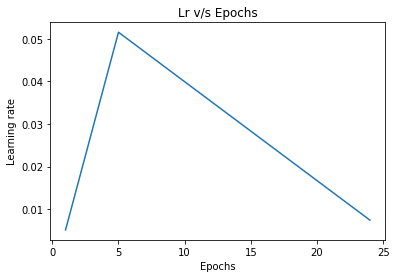

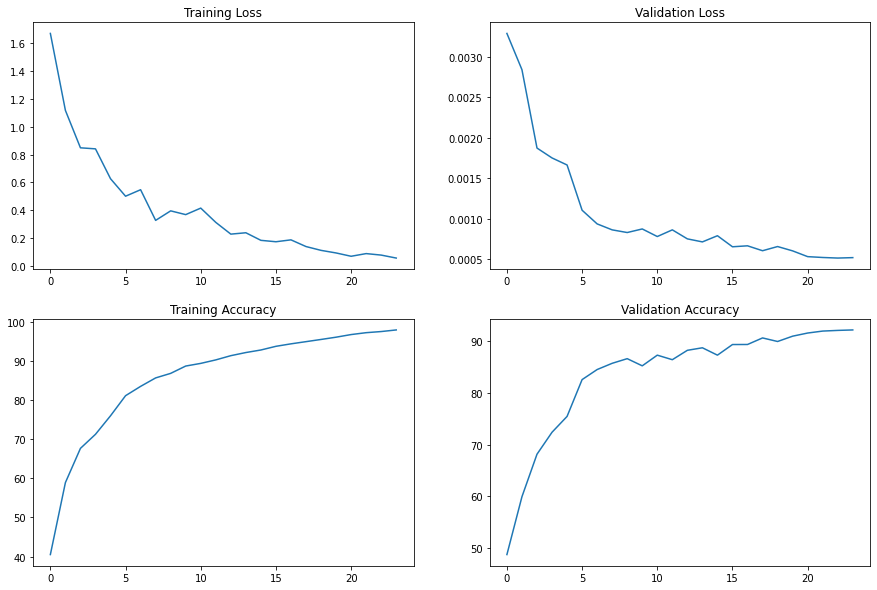

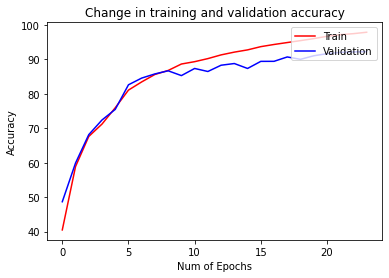

In [18]:
# train_obj.plot_cycle_lr()
Plot.plot_cycle_lr(25,train_obj.train_lr)
plt_obj = Plot(train_max_acc, train_min_loss, test_acc, test_losses)
plt_obj.display_all_plot()
plt_obj.plot_graph()


###Display 25 misclassified images

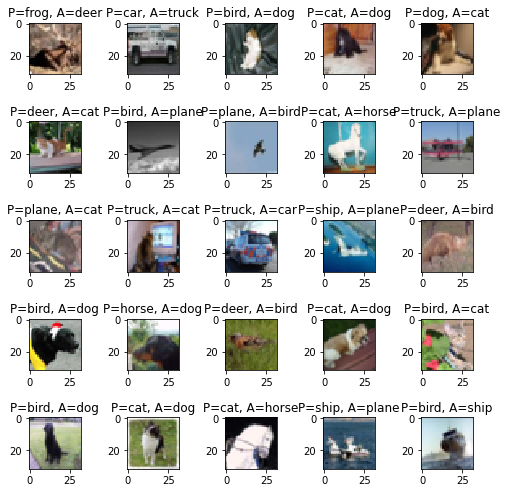

In [19]:
plt_obj.plot_cifar_misclassified(misclassified_images)

###Visualizing Gradcam results for 25 misclassified images in all layers

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


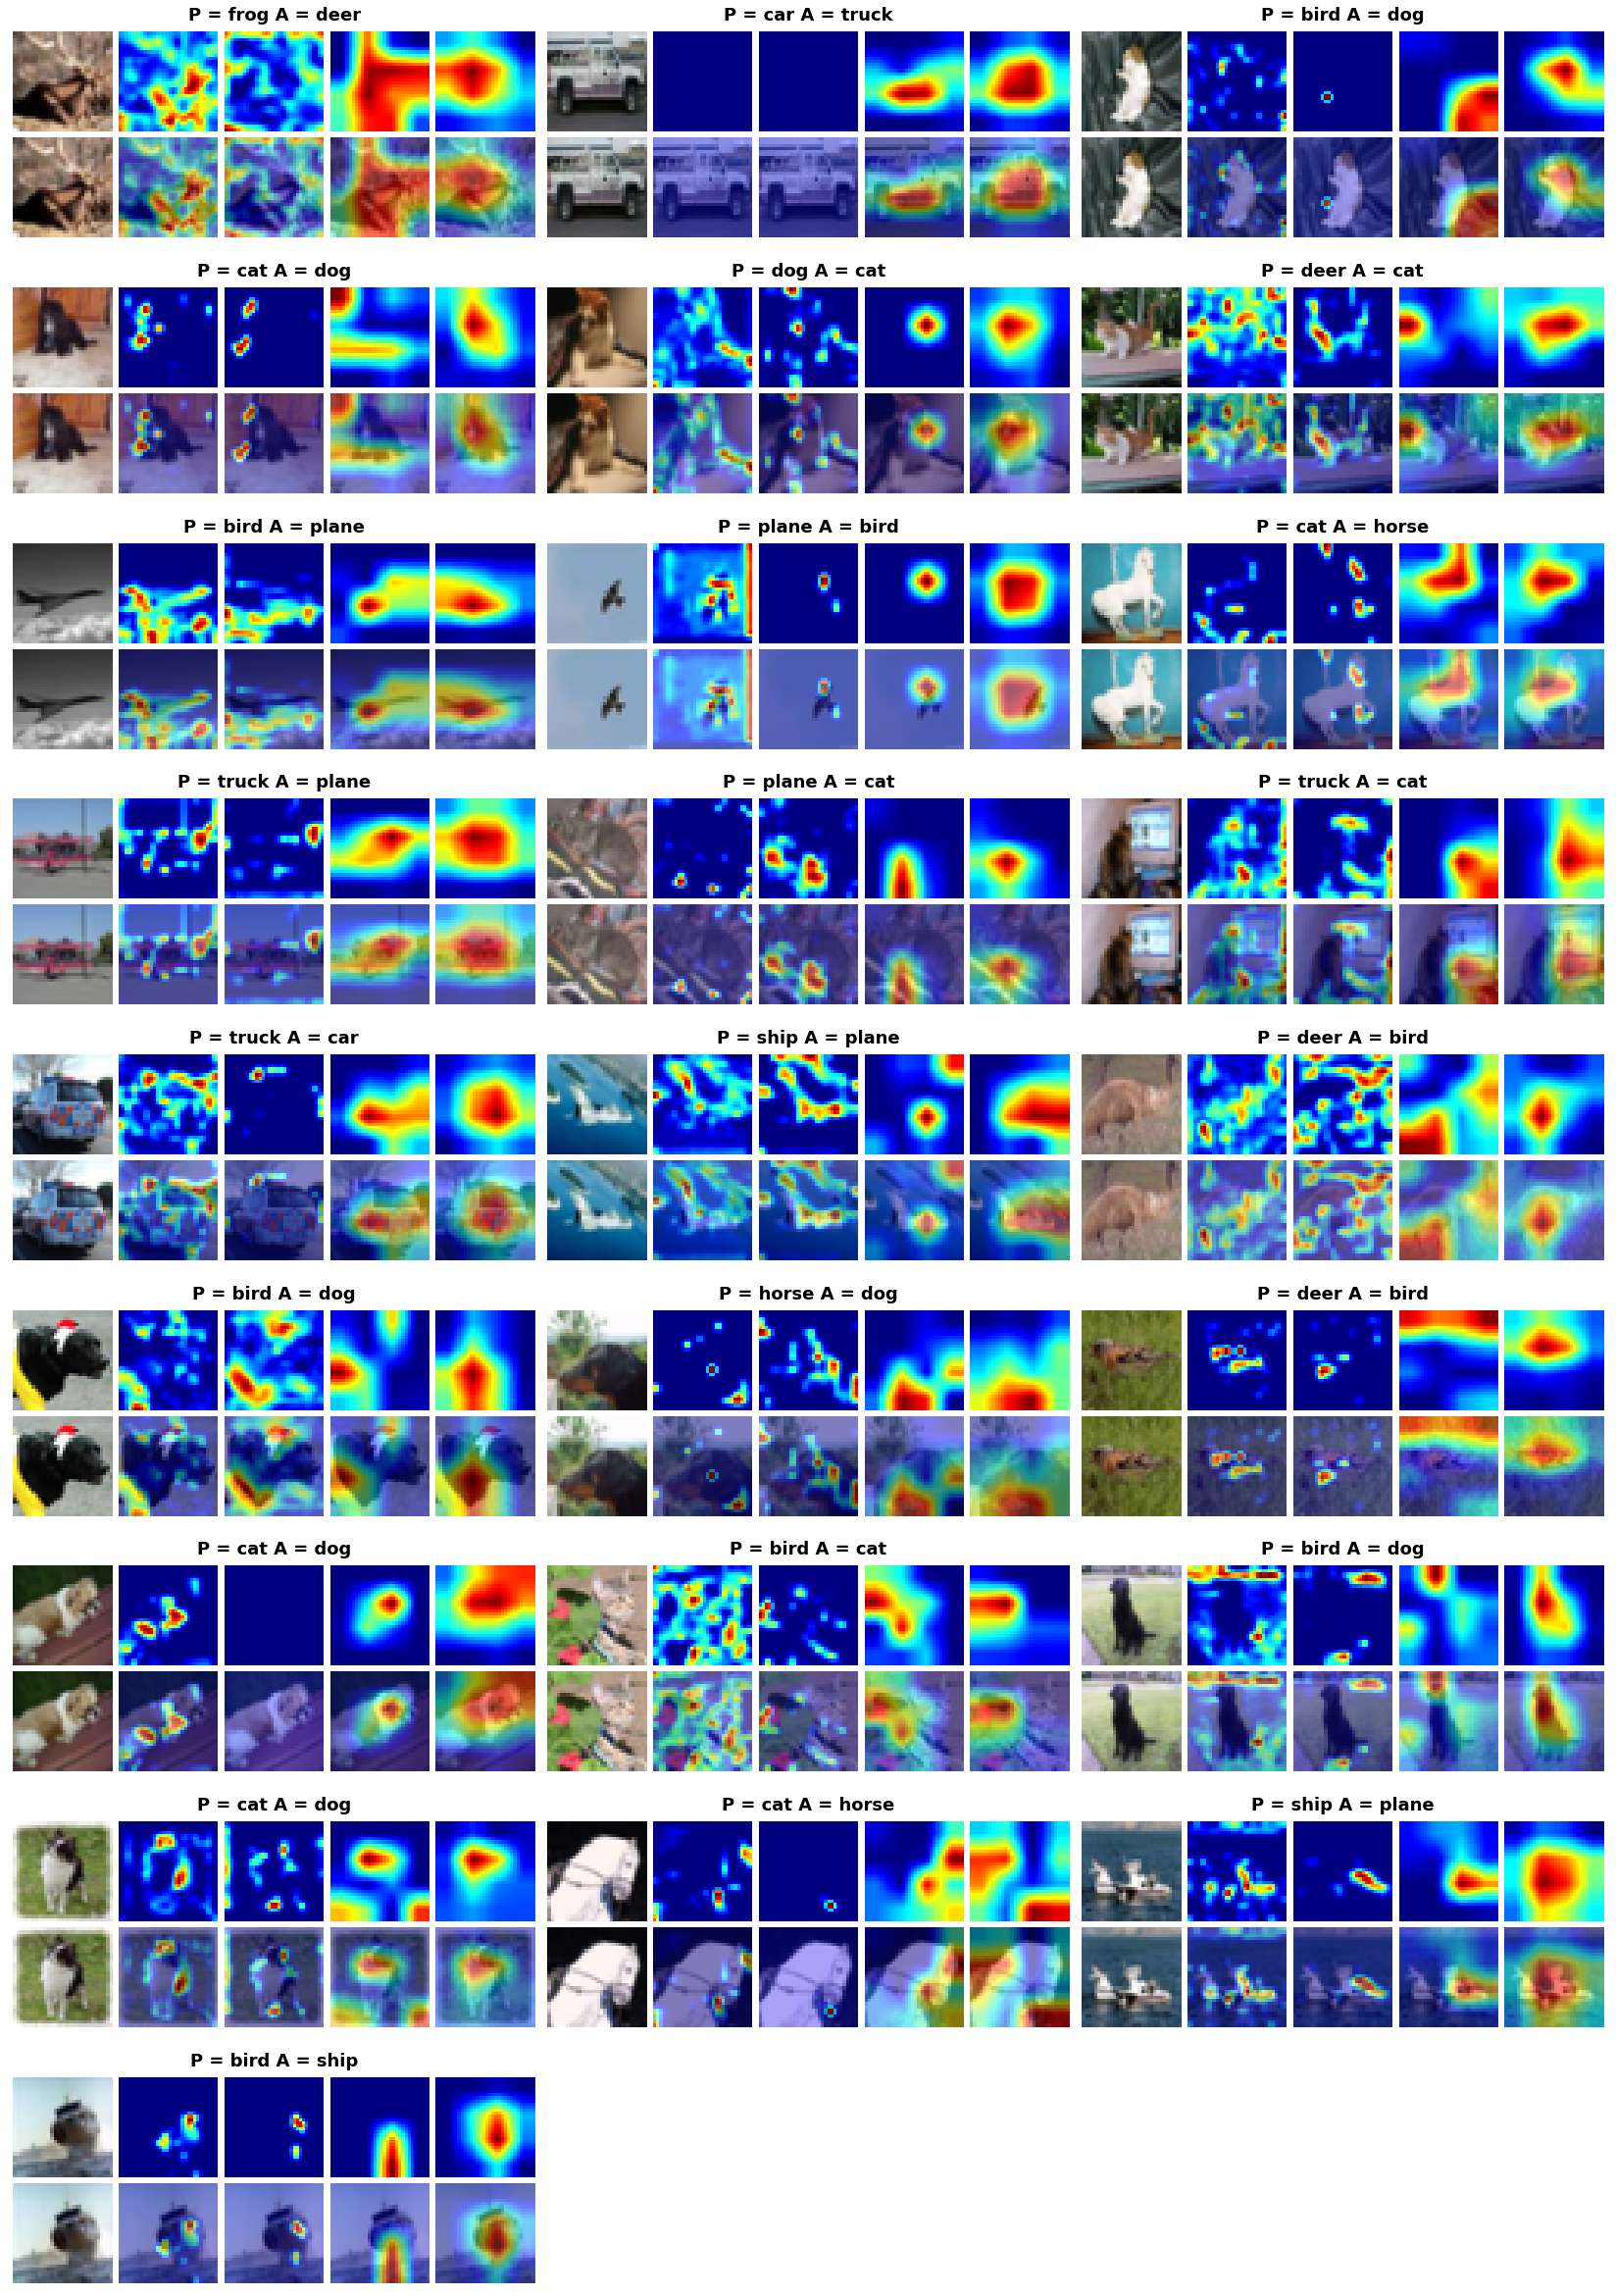

In [20]:
layers = [model.layer1, model.R1, model.layer3, model.R2]
helper_obj.get_gradcam_images(model,layers,misclassified_images,classes)